In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.pandas.set_option('display.max_columns',None)
pd.pandas.set_option('display.max_rows',None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('../input/jovian-pytorch-z2g/Human protein atlas/train.csv')
train.head(10)

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4
5,26562,9
6,1080,4
7,27886,4
8,30721,6
9,15838,1 4


In [3]:
train.shape

(19236, 2)

In [4]:
train.isnull().sum()

Image    0
Label    0
dtype: int64

In [5]:
from plotly.offline import iplot
import plotly as py
import plotly.tools as tls
import cufflinks as cf

py.offline.init_notebook_mode(connected = True)
cf.go_offline()

In [6]:
train['Label'].value_counts().iplot(kind='bar',theme='solar',color = [ 'gold'],title='Class distribution')

In [7]:
def encode_label(label):
    target = np.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

In [8]:
def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [9]:
label3 = []

for i in train['Label']:
    label3.append(encode_label(i))
    
label3 = np.array(label3)

In [10]:
label3.shape

(19236, 10)

In [11]:
train['Label'][2]

'1 4'

In [12]:
encode_label(train['Label'][2])

array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])

In [13]:
import gc
gc.collect()

858

In [14]:
DIR = '../input/jovian-pytorch-z2g/Human protein atlas/train'
img_dir = []

for i in train['Image']:
    img_dir.append(os.path.join(DIR,str(i))+'.png')
    
    


In [15]:
y = label3
x = np.array(img_dir)

In [16]:
SEED = 42
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.2,random_state = SEED)

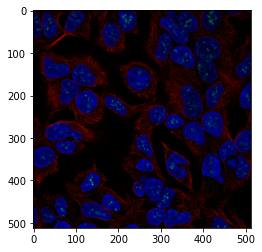

In [17]:
import cv2
import matplotlib.pyplot as plt

img = plt.imread(img_dir[100])
plt.imshow(img)

In [18]:
img.shape

(512, 512, 3)

In [19]:
test = pd.read_csv('../input/jovian-pytorch-z2g/submission.csv')
test.head()

,Image,Label
0,24117,0
1,15322,0
2,14546,0
3,8079,0
4,13192,0


In [20]:
TEST_DIR = '../input/jovian-pytorch-z2g/Human protein atlas/test'
test_img = []

for i in test['Image']:
    test_img.append(os.path.join(TEST_DIR,str(i))+'.png')

test_img = np.array(test_img)

## Data Loading:

In [21]:
import tensorflow as tf

In [22]:
img_size = 256
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 10

In [23]:
def decode_image(filename, label=None, image_size=(img_size,img_size)) :
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.bfloat16) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label == None :
        return image
    else :
        return image, label

In [24]:
bool_random_brightness = False
bool_random_contrast = False
bool_random_hue = False
bool_random_saturation = False

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if bool_random_brightness:
        image = tf.image.random_brightness(image,0.2,seed=seed)
    if bool_random_contrast:
        image = tf.image.random_contrast(image,0.6,1.4, seed=seed)
    if bool_random_hue:
        image = tf.image.random_hue(image,0.07,seed=seed)
    if bool_random_saturation:
        image = tf.image.random_saturation(image,0.5,1.5,seed=seed)
    
    if label is None:
        return image
    else:
        return image, label

In [25]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [26]:
test_dataset=(
    tf.data.Dataset
    .from_tensor_slices(test_img)
    .map(decode_image ,num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [27]:
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [28]:
def create_test_data(test_paths,aug=False):
    test_data = (
        tf.data.Dataset.from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls = AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    
    if aug == True :
        test_data = test_data.map(data_augment ,num_parallel_calls = AUTO)
    return test_data

# Model Building

In [29]:
channel = 3

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers,models

model = models.Sequential()
model.add(ResNet50(weights = 'imagenet',include_top=False,input_shape=(img_size,img_size,channel))
)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(10,activation='sigmoid'))




In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
model.compile(loss=tf.keras.losses.binary_crossentropy,optimizer='adam',metrics = ['acc'])

In [32]:
mc = tf.keras.callbacks.ModelCheckpoint('resnet50_model.h5',monitor='val_acc',mode='max',save_best_only=True,verbose=1)


In [ ]:
history = model.fit(train_dataset, 
        epochs=EPOCHS, 
        callbacks=[mc],
        steps_per_epoch=y_train.shape[0] // BATCH_SIZE,
        validation_data=valid_dataset,
        validation_steps=y_val.shape[0] // BATCH_SIZE
    )